**Rancel Hernandez**

**Jan 10, 2025**

**Student ID: 012218003**


# Medical Readmission Analysis using K-Means Clustering

## Project Overview
This project analyzes hospital patient data to identify patterns related to patient readmission using unsupervised machine learning techniques. By applying K-means clustering to continuous variables such as initial hospitalization duration, total charges, income, and other metrics, I aim to discover natural groupings of patients that could help healthcare providers identify high-risk individuals and implement targeted interventions.

## Research Question
**Do the clusters identified by k-means clustering reveal distinct patterns when visualized through t-SNE, and are these patterns related to readmission status or any categorical variables in the dataset?**

## Business Context
Hospital readmissions represent a significant healthcare challenge, leading to increased costs and potentially indicating issues with initial treatment. Understanding the factors that contribute to readmission can help hospitals improve patient outcomes and reduce unnecessary healthcare expenditures. Additionally, healthcare facilities face penalties from the Centers for Medicare and Medicaid Services (CMS) for high readmission rates, making this analysis particularly valuable for guiding initiatives to lower these rates.

## Dataset Description
The dataset contains information on 10,000 hospital patients including:
- Demographic information (age, income, gender)
- Clinical metrics (initial days stayed, vitamin D levels)
- Medical conditions (diabetes, high blood pressure, anxiety)
- Financial data (total charges, additional charges)
- Outcome measures (readmission status)

## Imports
- Install yellowbrick
- Upgrade scikit-learn (Optional)

In [2]:
# import sys to install yellowbrick for the silhouette plot
import sys

!{sys.executable} -m pip install yellowbrick > /dev/null 2>&1

In [3]:
# used to load data into a DataFrame
import pandas as pd

# used to plot the data points to visualize the clusters
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# implement kmeans and scale the data 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# assess the quality of the clusters
from sklearn.metrics import silhouette_score

# to create the silhouette plot
from yellowbrick.cluster import SilhouetteVisualizer

## Load and Prep the data
- Load data
- Declare intial set of variables
- Scale the data
- Identify Outliers, Missing values, and Duplicates

In [4]:
# path to the dataset
file_path = '/Users/rancelhernandez/Downloads/d8fj4l3d9s94jfu43kf9/medical_clean.csv'

# load the data from the CSV file into medical_df
medical_df = pd.read_csv(file_path)

In [5]:
# Data Preprocessing Plan Step 1 [cell 5] scale the data

# declare the initial set of variables for kmeans
cont_vars = [
    'Income',
    'Initial_days',
    'TotalCharge',
    'Age',
    'Additional_charges',
    'Population',
    'VitD_levels'
]

# scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(medical_df[cont_vars])


Summary Statistics for 'Income'
Mean: 149508.08
Median: 145193.0
Min: 126063.69
Max: 207249.1
Range: 81185.41


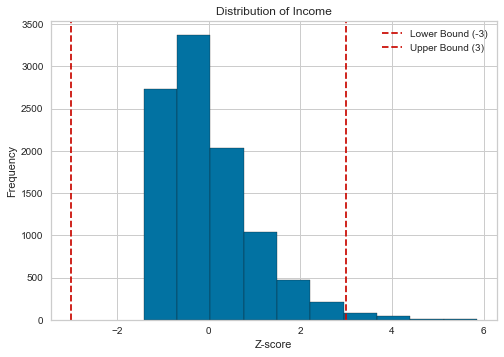


Summary Statistics for 'Population'
Mean: 67419.33
Median: 63165.0
Min: 54453
Max: 122814
Range: 68361


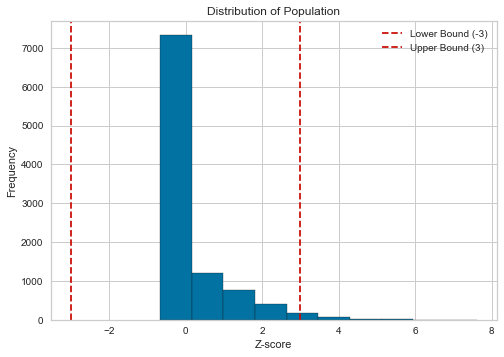


Summary Statistics for 'VitD_levels'
Mean: 19.09
Median: 24.26
Min: 9.81
Max: 26.39
Range: 16.59


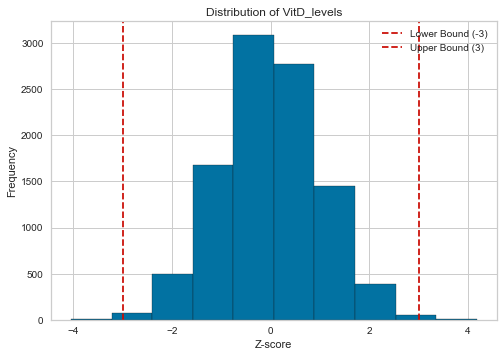

In [6]:
# Data Preprocessing Plan Step 2 [cell 6] identify outliers

# at each iteration calculate the zscores for the current variable an dcheck if there are any outliers
for var in range(scaled_data.shape[1]):
    
    # any data point 3 stds from the mean is considered an outlier
    mask = abs(scaled_data[:, var]) > 3
    
    # check if any outliers
    if len(scaled_data[:, var][mask]) > 0:
        
        # print the summary statistics of the outliers
        print("\nSummary Statistics for '" + cont_vars[var] + "'\nMean:", round(medical_df[cont_vars[var]][mask].mean(), 2))
        print("Median:", round(medical_df[cont_vars[var]][mask].median(), 2))
        print("Min:", round(medical_df[cont_vars[var]][mask].min(), 2))
        print("Max:", round(medical_df[cont_vars[var]][mask].max(), 2))
        print("Range:", round(medical_df[cont_vars[var]][mask].max() - medical_df[cont_vars[var]][mask].min(), 2))
        
        # plot histogram to view the distribtuion
        plt.hist(scaled_data[:, var], edgecolor='k')
    
        # add titles and labels
        plt.title('Distribution of ' + cont_vars[var])
        plt.xlabel('Z-score')
        plt.ylabel('Frequency')

        # add outlier bounds
        plt.axvline(x=-3, color='r', linestyle='--', label='Lower Bound (-3)')
        plt.axvline(x=3, color='r', linestyle='--', label='Upper Bound (3)')
        plt.legend()
        plt.show()

In [7]:
# Data Preprocessing Plan Step 3 [cell 7] remove duplicates

# compare the unique count of patient IDs to total number of entries
# if these are equal then no duplicates, else there are duplicates
if medical_df['Customer_id'].nunique() == medical_df['Customer_id'].count():
    print("There are no duplicated patient entries.")
else:
    print("There are duplicated patient entries.")

There are no duplicated patient entries.


In [8]:
# Data Preprocessing Plan Step 4 [cell 8] identify missing values

# print the total number of missing values in the columns
print(medical_df.isna().sum())

CaseOrder             0
Customer_id           0
Interaction           0
UID                   0
City                  0
State                 0
County                0
Zip                   0
Lat                   0
Lng                   0
Population            0
Area                  0
TimeZone              0
Job                   0
Children              0
Age                   0
Income                0
Marital               0
Gender                0
ReAdmis               0
VitD_levels           0
Doc_visits            0
Full_meals_eaten      0
vitD_supp             0
Soft_drink            0
Initial_admin         0
HighBlood             0
Stroke                0
Complication_risk     0
Overweight            0
Arthritis             0
Diabetes              0
Hyperlipidemia        0
BackPain              0
Anxiety               0
Allergic_rhinitis     0
Reflux_esophagitis    0
Asthma                0
Services              0
Initial_days          0
TotalCharge           0
Additional_charg

## Cluster Evaluation and Optimization
- Calculate the inertia for the k-means models with n-range clusters
- Calculate the Silhouette score for each model
- Visualize the Elbow plot
- Select optimal clusters 
- Assess the quality of the clusters in Silhouette plot
- Compare separation of features for each cluster

In [9]:
# D2 Elbow Plot [cell 9]

# store the inertia values of all the kmeans models
inertias = []

# the cluster values that will be tested
num_clusters = range(1, 8)

# at each iteration declare a kmeans model with n number of clusters
# fit the data and store the inertia value of the model
for n in num_clusters:
    
    # set n_init to 50 to ensure the model converges
    # n_init - changes the number of iterations (default 10 iterations)
    # due to random initialization, it may not always converge
    kmeans_model = KMeans(n_clusters=n, n_init=50)
    kmeans_model.fit(scaled_data)
    inertias.append(kmeans_model.inertia_)
    
    # rassign cluster labels to use in silhouette_score
    medical_df['cluster_labels'] = kmeans_model.predict(scaled_data)
    
    # silhouette_score requires at least 2 clusters so skip when n is 1
    if n == 1:
        continue
        
    # calcualte the silhouette_score for current number of clsuters
    sil_score = silhouette_score(scaled_data, medical_df['cluster_labels'])
    
    # print the score
    print(F"Silhouette Score at {n} clusters:", round(sil_score, 4))
    
print("\nInertias:", inertias)

Silhouette Score at 2 clusters: 0.2652
Silhouette Score at 3 clusters: 0.2181
Silhouette Score at 4 clusters: 0.2101
Silhouette Score at 5 clusters: 0.2177
Silhouette Score at 6 clusters: 0.2206
Silhouette Score at 7 clusters: 0.198

Inertias: [70000.0, 51830.51234224782, 45430.13025970123, 39627.79984685663, 35715.297146380086, 32924.08626165775, 31161.066289167407]


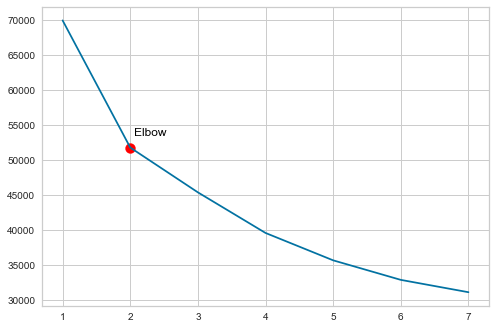

In [10]:
# D2 Elbow Plot[cell 10]

# plot the number of clusters and their inertia values to select the 
# the optimal number of clusters
sns.lineplot(x=num_clusters, y=inertias)

# add a marker at two clusters
plt.scatter(num_clusters[1], inertias[1], color='red', s=100, label='Elbow Point')

# add label at the elbow around the marker (2.3, 53000)
plt.text(2.3, 53500, 'Elbow', color='black', fontsize=12, ha='center') 
plt.show()

In [11]:
# two clusters were determined to be the optimal number,
# as the decrease in inertia becomes less significant after this point.
best_model = KMeans(n_clusters=2, n_init=50)
best_model.fit(scaled_data)
medical_df['cluster_labels'] = best_model.predict(scaled_data)

In [12]:
# switch to scikit-learn version 0.24 for compatibility  and hide the output
!{sys.executable} -m pip install scikit-learn==0.24 > /dev/null 2>&1

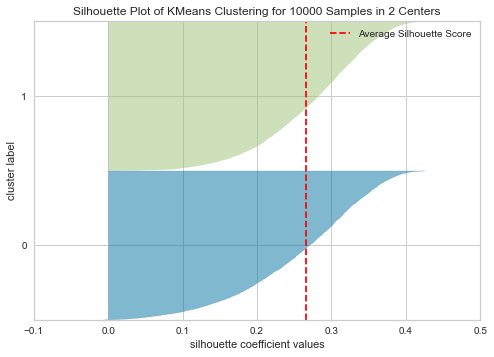

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 10000 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [13]:
# initialize the SilhouetteVisualizer object passing the model with 2 clusters
visualizer = SilhouetteVisualizer(best_model, colors='yellowbrick')

# fit the model and visualize the silhouette plot
visualizer.fit(scaled_data)  

visualizer.show()

In [14]:
# get the cluster centroids 
scaled_centroids = best_model.cluster_centers_

# de-standardize the centroids to the original scale
original_centroids = scaler.inverse_transform(scaled_centroids)

# iterate through each centroid and then iterate and round through each value in that centroid
rounded_centroids = [[round(value, 2) for value in centroid] for centroid in original_centroids]

# print each centroid with corresponding feature names
for i, centroid in enumerate(rounded_centroids):
    
    # i will be the cluster identification
    print(f"\nCluster {i + 1} Centroids:")
    
    # j is the index to get the corresponding var in cont_vars
    for j, value in enumerate(centroid):
        print(f"{cont_vars[j]}: {value}")


Cluster 1 Centroids:
Income: 40234.31
Initial_days: 59.68
TotalCharge: 7376.63
Age: 53.84
Additional_charges: 12977.84
Population: 10189.08
VitD_levels: 17.95

Cluster 2 Centroids:
Income: 40746.78
Initial_days: 9.22
TotalCharge: 3246.89
Age: 53.19
Additional_charges: 12891.2
Population: 9741.34
VitD_levels: 17.98


## t-SNE Visualization of Clusters
- Initialize, fit, and transform the TSNE model 
- Plot the reduced high dimensional data
- Color the data points by each categorical variable 


### Research Question

- Do the clusters identified by k-means clustering reveal distinct patterns when visualized through t-SNE, and are these patterns related to readmission status or any categorical variables in the dataset?

In [15]:
# create TSNE model to plot the high dimensional data in 2d
# with an alpha 10
model = TSNE(learning_rate=10, random_state=100)

# fit and transform the scaled data
transformed = model.fit_transform(scaled_data)

# split the data to the corresponding axis
xs = transformed[:, 0]
ys = transformed[:, 1]

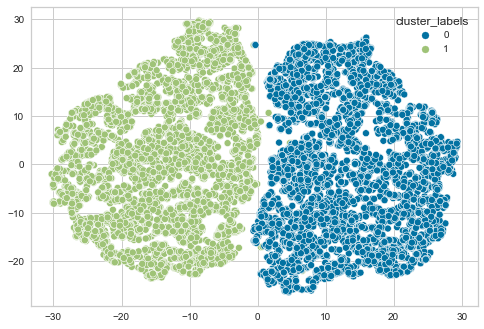

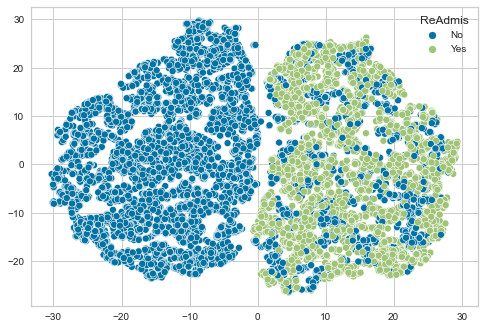

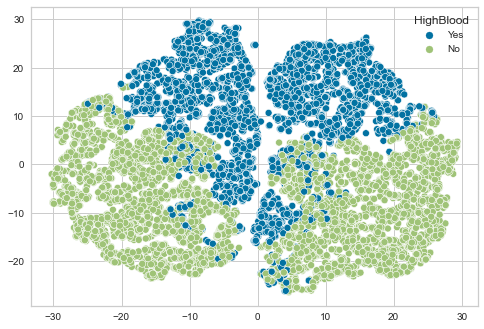

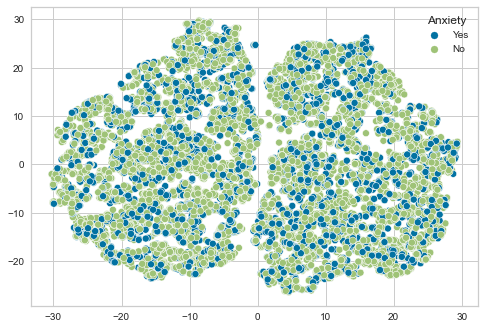

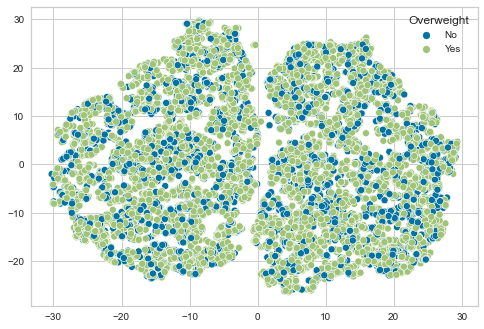

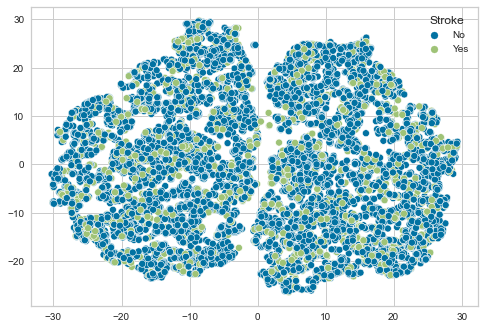

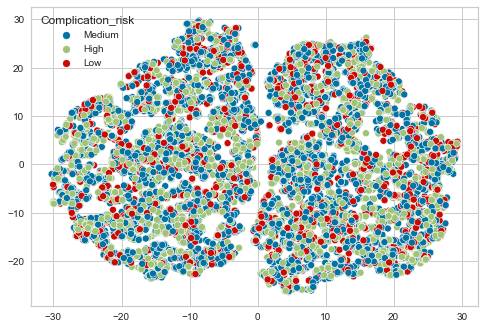

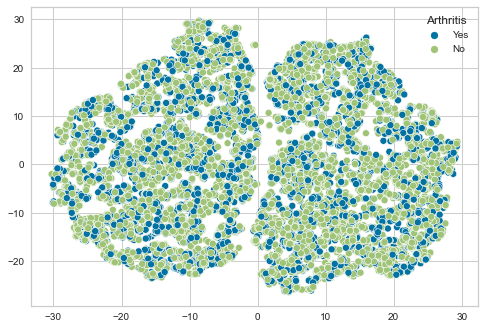

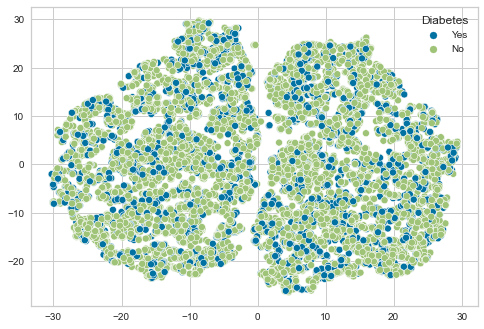

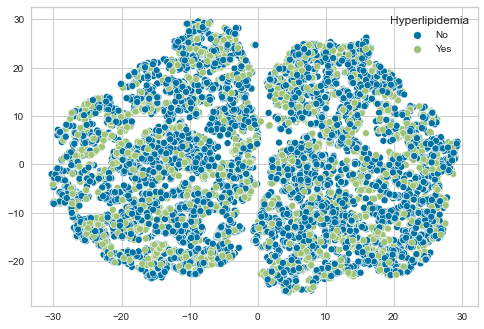

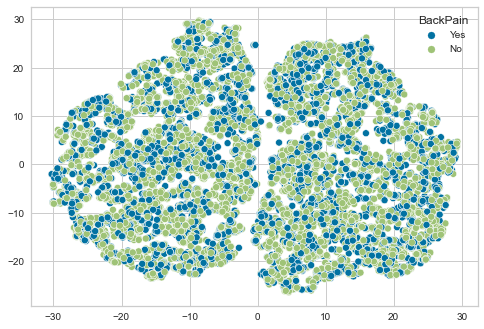

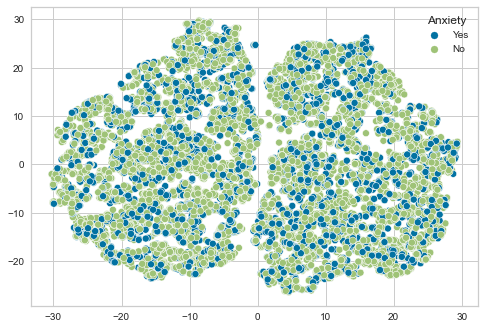

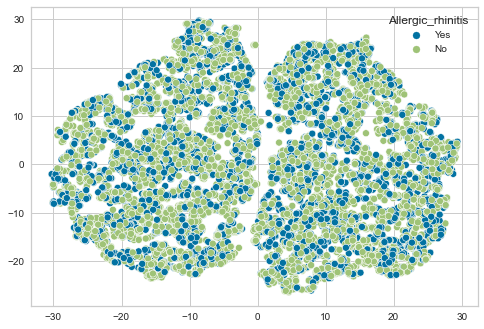

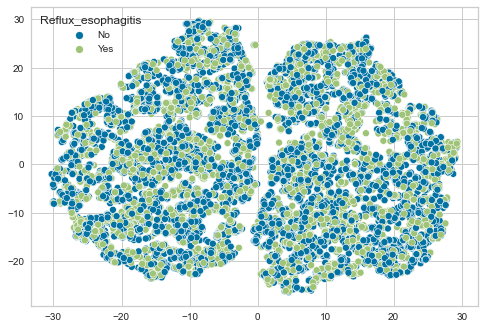

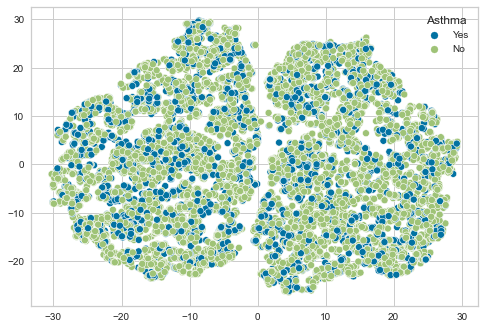

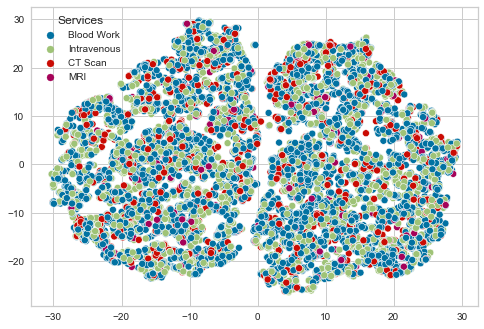

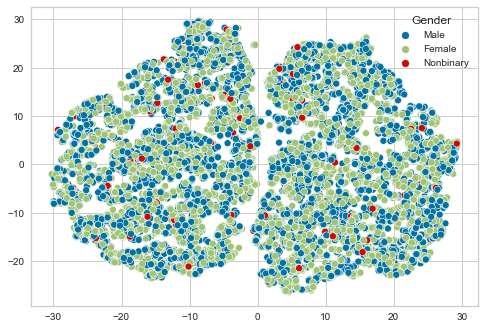

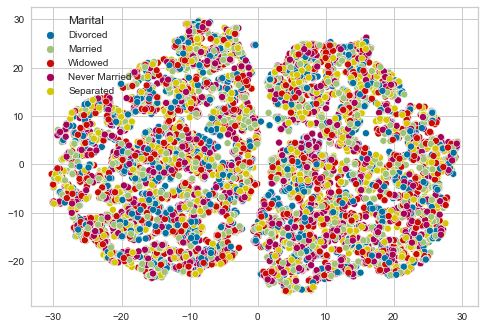

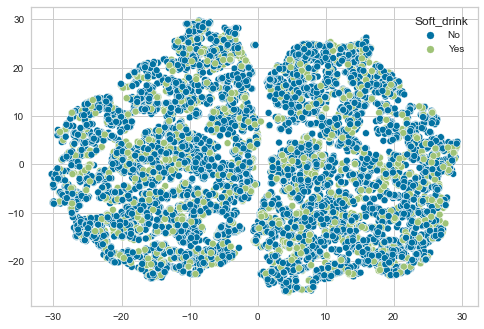

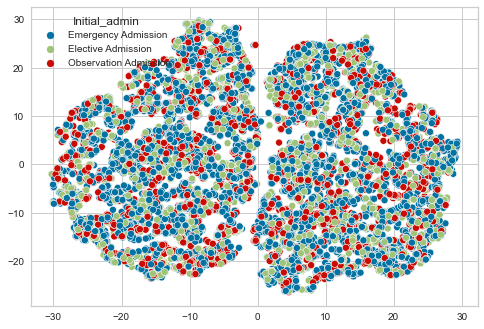

In [16]:
# declare the list of categorical variables to color the scatter plot
cat_vars = [
    'cluster_labels',
    'ReAdmis',
    'HighBlood',
    'Anxiety',
    'Overweight',
    'Stroke',
    'Complication_risk',
    'Arthritis',
    'Diabetes',
    'Hyperlipidemia',
    'BackPain',
    'Anxiety',
    'Allergic_rhinitis',
    'Reflux_esophagitis',
    'Asthma',
    'Services',
    'Gender',
    'Marital',
    'Soft_drink',
    'Initial_admin'
]


# at each iteration plot the data and change the hue value to the current categorical variable
for var in cat_vars:
    
    sns.scatterplot(x=xs, y=ys, hue=medical_df[var])
    
    plt.show()

## Explore the Relationship of the Clusters and Readmission
- Analyze the distribution of readmitted patients
- Print the cross-tabulation tables for the clusters and readmission
- Compare the separation of k-means and readmission cluster
- Visualize the clusters using relevant features
- Explore underlying data patterns

In [17]:
# check the distribution of readmitted patients
print(medical_df['ReAdmis'].value_counts())

No     6331
Yes    3669
Name: ReAdmis, dtype: int64


In [18]:
# print the cross tabulation tables betwen the cluster labels and columns of interest

crosstab_rs = pd.crosstab(medical_df['cluster_labels'], medical_df['ReAdmis'])
print(crosstab_rs, "\n")

crosstab_hb = pd.crosstab(medical_df['cluster_labels'], medical_df['HighBlood'])
print(crosstab_hb, "\n")

# this column was inluded to see the distribution of the labels between a column
# that produced randomly scattered data points
crosstab_ow = pd.crosstab(medical_df['cluster_labels'], medical_df['Overweight'])
print(crosstab_ow)

ReAdmis           No   Yes
cluster_labels            
0               1331  3669
1               5000     0 

HighBlood         No   Yes
cluster_labels            
0               2961  2039
1               2949  2051 

Overweight        No   Yes
cluster_labels            
0               1486  3514
1               1420  3580


In [19]:
# check the proportions of the cluster_labels
print(medical_df['cluster_labels'].value_counts())

# create two masks at each iteration to get the mean of each continuous variable 
# split by 'cluster_labels' and 'ReAdmis'
for var in cont_vars:
    
    # there are two cluster 0 and 1 
    mask_cl = medical_df['cluster_labels'] == 0
    
    # readmission status 'No' and 'Yes'
    mask_rs = medical_df['ReAdmis'] == 'No'
    
    # print he mean for each continuous variable split by cluster and readmission status
    print(F"\n'cluster_labels' is 0 {var}:", round(medical_df[var][mask_cl].mean(), 2))
    print(F"'cluster_labels' is 1 {var}:", round(medical_df[var][~mask_cl].mean(), 2))
    print(F"\n'ReAdmis' is 'No' {var}:", round(medical_df[var][mask_rs].mean(), 2))
    print(F"'ReAdmis' is 'Yes' {var}:", round(medical_df[var][~mask_rs].mean(), 2))

1    5000
0    5000
Name: cluster_labels, dtype: int64

'cluster_labels' is 0 Income: 40240.25
'cluster_labels' is 1 Income: 40740.74

'ReAdmis' is 'No' Income: 40740.26
'ReAdmis' is 'Yes' Income: 40059.52

'cluster_labels' is 0 Initial_days: 59.68
'cluster_labels' is 1 Initial_days: 9.23

'ReAdmis' is 'No' Initial_days: 17.41
'ReAdmis' is 'Yes' Initial_days: 63.86

'cluster_labels' is 0 TotalCharge: 7377.08
'cluster_labels' is 1 TotalCharge: 3247.26

'ReAdmis' is 'No' TotalCharge: 3911.77
'ReAdmis' is 'Yes' TotalCharge: 7728.62

'cluster_labels' is 0 Age: 53.83
'cluster_labels' is 1 Age: 53.19

'ReAdmis' is 'No' Age: 53.26
'ReAdmis' is 'Yes' Age: 53.94

'cluster_labels' is 0 Additional_charges: 12976.19
'cluster_labels' is 1 Additional_charges: 12892.87

'ReAdmis' is 'No' Additional_charges: 12866.7
'ReAdmis' is 'Yes' Additional_charges: 13051.58

'cluster_labels' is 0 Population: 10190.13
'cluster_labels' is 1 Population: 9740.38

'ReAdmis' is 'No' Population: 9739.1
'ReAdmis' is 'Ye

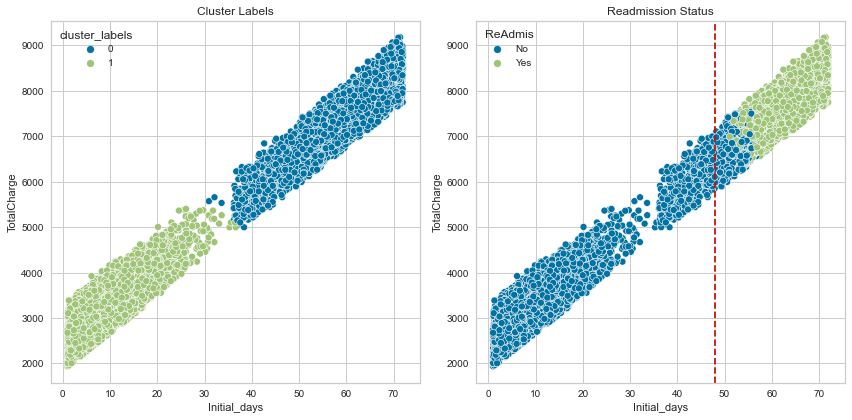

In [20]:
# plot initial days  vs. total charge and color by 'cluster_labels' / 'ReAdmis'

# create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# first scatter plot: Cluster labels
sns.scatterplot(x=medical_df['Initial_days'], y=medical_df['TotalCharge'], hue=medical_df['cluster_labels'], ax=axes[0])
axes[0].set_title('Cluster Labels')

# second scatter plot: Readmission status
sns.scatterplot(x=medical_df['Initial_days'], y=medical_df['TotalCharge'], hue=medical_df['ReAdmis'], ax=axes[1])
axes[1].set_title('Readmission Status')

# add 48 day line mark to indicate the min stay of readmitted patients
plt.axvline(x=48, color='r', linestyle='--', label='48 Days')

# adjust the layout for better spacing and display the plots
plt.tight_layout()
plt.show()

In [21]:
# find out the minimum duration of the readmitted patients
mask = medical_df['ReAdmis'] == 'Yes'
print("Minnimum Initial_days of readmitted patients:", medical_df['Initial_days'][mask].min())

Minnimum Initial_days of readmitted patients: 48.43358


In [22]:
# use the threshold to get a value counts of the readmission status
mask = medical_df['Initial_days'] < 48.43358

print("Below ~48 initial days:\n", medical_df['ReAdmis'][mask].value_counts())

print("\nOver ~48 initial days:\n", medical_df['ReAdmis'][~mask].value_counts())

Below ~48 initial days:
 No    5611
Name: ReAdmis, dtype: int64

Over ~48 initial days:
 Yes    3669
No      720
Name: ReAdmis, dtype: int64


In [23]:
# create a mask to get a count of patients below and above the mean
mask = medical_df['Initial_days'] > medical_df['Initial_days'].mean()

print("Initial_days mean:", medical_df['Initial_days'].mean())
print("Patient count below the mean:", medical_df['Initial_days'][mask].count())
print("Patient count above the mean:", medical_df['Initial_days'][~mask].count())

Initial_days mean: 34.45529926595239
Patient count below the mean: 5002
Patient count above the mean: 4998


In [24]:
# count the number of patients not readmitted that stayed over the natural gap
mask = (medical_df['ReAdmis'] == 'No') & (medical_df['Initial_days'] > medical_df['Initial_days'].mean())

print("Patients not readmitted that stayed over the natural gap:", medical_df['ReAdmis'][mask].count())

Patients not readmitted that stayed over the natural gap: 1333


In [25]:
# range for intials days by readmission status
mask = medical_df['ReAdmis'] == 'Yes'
print("No:", medical_df['Initial_days'][~mask].min(), '-', medical_df['Initial_days'][~mask].max())
print("Yes:", medical_df['Initial_days'][mask].min(), '-', medical_df['Initial_days'][mask].max())

No: 1.001980919 - 59.34609
Yes: 48.43358 - 71.98149


## Explore the  Horizontal Relationship of the Clusters and HighBlood
- Analyze the distribution of patients with high blood pressure
- Compare the separation between high blood pressure
- Visualize the trends using relevant features

In [26]:
# check the proportions of patients with high blood pressure
print(medical_df['HighBlood'].value_counts())

# create a mask at each iteration to get the mean of each continuous variable split by 'HighBlood' status
for var in cont_vars:
    mask = medical_df['HighBlood'] == 'Yes'
    
    # print the mean of each continuous variable by 'HighBlood' status
    print(F"\n'HighBlood' is 'Yes' {var}:", round(medical_df[var][mask].mean(), 2))
    print(F"'HighBlood' is 'No' {var}:", round(medical_df[var][~mask].mean(), 2))

No     5910
Yes    4090
Name: HighBlood, dtype: int64

'HighBlood' is 'Yes' Income: 40444.11
'HighBlood' is 'No' Income: 40522.59

'HighBlood' is 'Yes' Initial_days: 34.26
'HighBlood' is 'No' Initial_days: 34.59

'HighBlood' is 'Yes' TotalCharge: 5364.35
'HighBlood' is 'No' TotalCharge: 5276.06

'HighBlood' is 'Yes' Age: 53.69
'HighBlood' is 'No' Age: 53.39

'HighBlood' is 'Yes' Additional_charges: 18080.27
'HighBlood' is 'No' Additional_charges: 9373.43

'HighBlood' is 'Yes' Population: 10139.25
'HighBlood' is 'No' Population: 9844.84

'HighBlood' is 'Yes' VitD_levels: 17.98
'HighBlood' is 'No' VitD_levels: 17.95


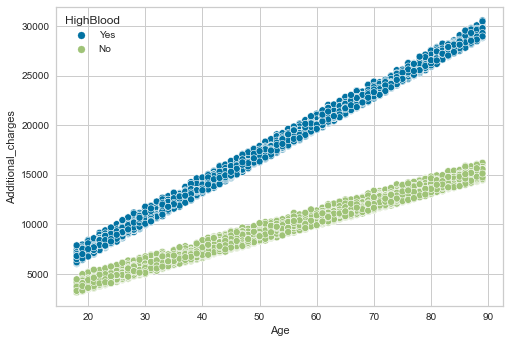

In [27]:
# plot 'Age' vs. 'Additional_charges' and color by 'HighBlood'
sns.scatterplot(x=medical_df['Age'], y=medical_df['Additional_charges'], hue=medical_df['HighBlood'])
plt.show()

## Conduct Hyperparameter Search
- Create the scaler object
- At each iteration, create a t-SNE model with a specified learning rate
- Visualize the scatter plot with data points colored by cluster labels

i: 10


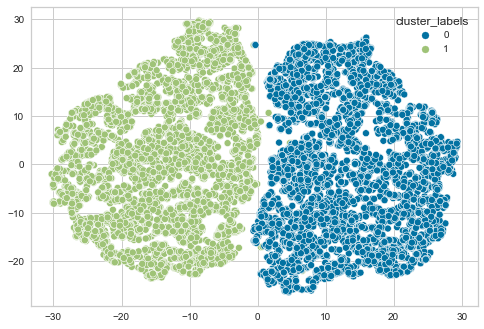

In [28]:
# create a scaler 
# then fit and transform the values
scaler = StandardScaler()
scaled_data = scaler.fit_transform(medical_df[cont_vars])

# set to 11 to show first iteration
# change to 151 to see all iterations
num = 11

# 'i' values tested [10, 30, 50, 70, 90, 110, 130, 150]
for i in range(10, num, 20):
    
    print("i:", i)
    
    # create the model with the current i value for the parameters being tuned (learning rate)
    model = TSNE(learning_rate=i, random_state=100)
    
    # fit the model and transform the data
    transformed = model.fit_transform(scaled_data)
    
    # set the axis accordingly
    xs = transformed[:,0]
    ys = transformed[:,1]
    
    # plot the cluster labels
    sns.scatterplot(x=xs, y=ys, hue=medical_df['cluster_labels'])
    plt.show()

## Export Data
- Convert the scaled numpy array to a DataFrame
- Export the Data to a CSV file

In [29]:
# convert the scaled data into a DataFrame to distinguish the values by column 
# and export into a CSV file
scaled_data_df = pd.DataFrame(scaled_data, columns=cont_vars)

In [30]:
# export scaled data df into a CSV file
#scaled_data_df.to_csv('scaled_data_T1.csv', index=False)

## Section 1: Calculate Separation Between Clusters (Feature Importance)
- Add cluster labels to the scaled DataFrame
- Initialize a dictionary to store the variation scores
- Calculate the absolute difference in means for each feature between clusters
- Sort features by their separation score
- Print the sorted features with separation scores

In [31]:
# add the cluster labels to the scaled df
scaled_data_df['cluster_labels'] = medical_df['cluster_labels']

# initiate dictionary to collect variation scores
variation_scores = {}

# create a mask to segment the data by cluster 
mask = scaled_data_df['cluster_labels'] == 0

# iterate through each feature and calculate the separation between features for each cluster
for var in cont_vars:
    cluster_0_std = scaled_data_df[var][mask].mean()
    cluster_1_std = scaled_data_df[var][~mask].mean()
    
    # calculate the separation as the absolute difference of the means
    variation_scores[var] = abs(cluster_0_std - cluster_1_std)

# sort features by their separation
sorted_features = sorted(variation_scores.items(), key=lambda x: x[1])

# print sorted features with variation scores
for feature, score in sorted_features:
    print(f"{feature}: {round(score, 4)}")

Additional_charges: 0.0127
VitD_levels: 0.0128
Income: 0.0175
Population: 0.0303
Age: 0.0312
TotalCharge: 1.8942
Initial_days: 1.9177


## Section 2: Iterative Feature Reduction
- Initialize the t-SNE model for dimensionality reduction
- Iteratively remove features with low separation scores
- Scale the data after each feature removal
- Fit the k-means model and predict cluster labels
- Calculate the silhouette score for each updated feature set
- Visualize the clusters with a scatter plot (t-SNE) and silhouette plot

Current features: ['Income', 'Initial_days', 'TotalCharge', 'Age', 'Population', 'VitD_levels']
Silhouette Score: 0.30474895586680867


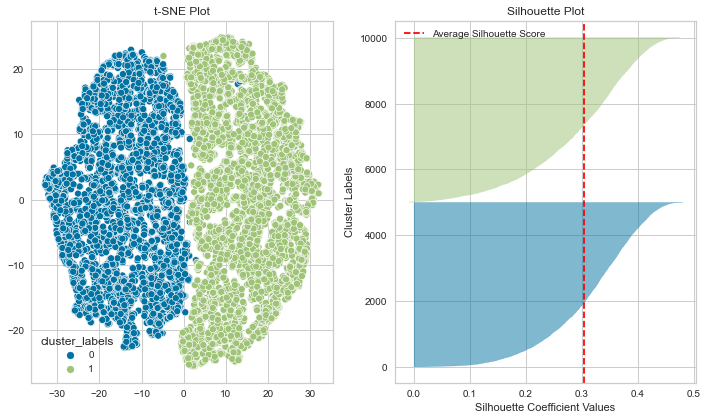

Current features: ['Income', 'Initial_days', 'TotalCharge', 'Age', 'Population']
Silhouette Score: 0.36631901019977986


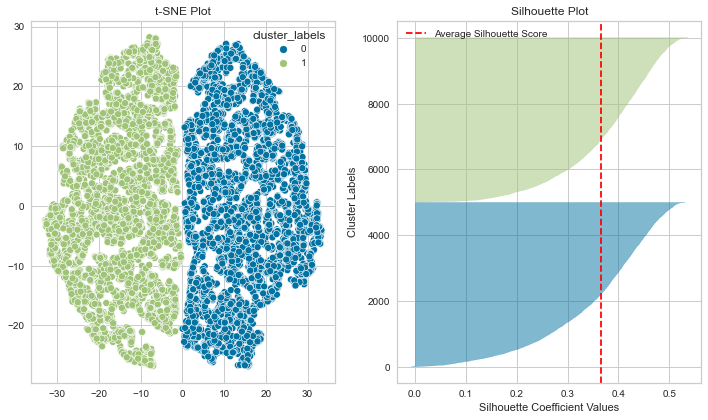

Current features: ['Initial_days', 'TotalCharge', 'Age', 'Population']
Silhouette Score: 0.44881940562076195


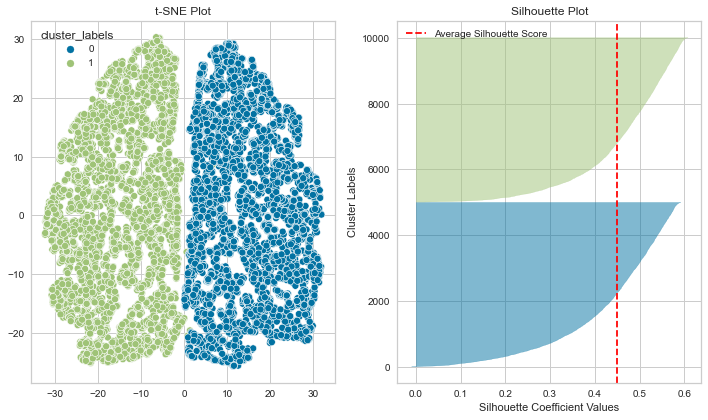

Current features: ['Initial_days', 'TotalCharge', 'Age']
Silhouette Score: 0.5509294878010229


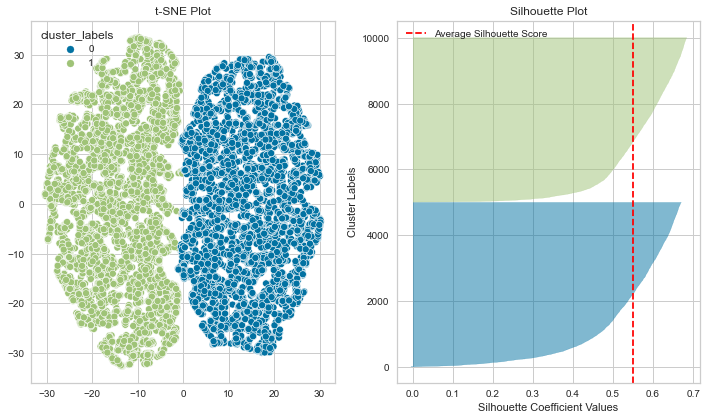

Current features: ['Initial_days', 'TotalCharge']
Silhouette Score: 0.8030913563541215


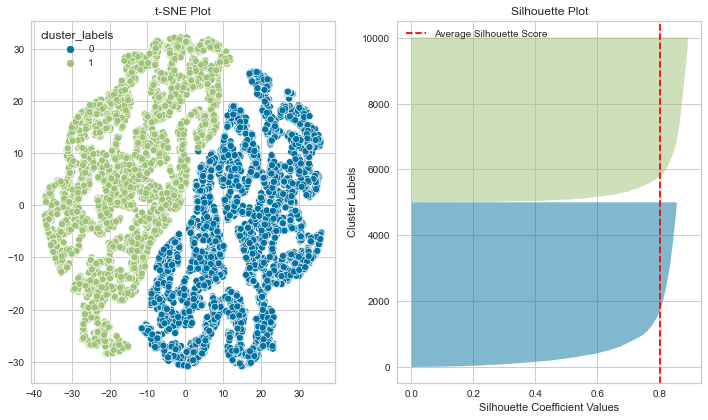

In [32]:
# initialize the t-SNE model for plotting iteratively reduced data
model = TSNE(learning_rate=10, random_state=100)

# iterate the sorted features  
for var in sorted_features:
    
    # break the loop if theres only two features left 
    # t-SNE is for high dimensional data
    if len(cont_vars) == 2:
        break
        
    # remove the current variable from the continuous variables 
    cont_vars.remove(var[0])
    print("Current features:", cont_vars)
    
    # scale the data for the updated feature set
    scaled_data = scaler.fit_transform(medical_df[cont_vars])
    
    # it the KMeans model with the updated feature set
    best_model.fit(scaled_data)

    # predict cluster labels using the updated DataFrame
    medical_df['cluster_labels'] = best_model.predict(scaled_data)
    
    # calculate the silhouette score
    sil_score = silhouette_score(scaled_data, medical_df['cluster_labels'])
    print("Silhouette Score:", sil_score)
    
    # fit and transform the scaled data using t-sne
    transformed = model.fit_transform(scaled_data)

    # split the data to the corresponding axis
    xs = transformed[:, 0]
    ys = transformed[:, 1]

    # create the figure for side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    # scatter plot
    sns.scatterplot(x=xs, y=ys, hue=medical_df['cluster_labels'], ax=axes[0])
    axes[0].set_title("t-SNE Plot")

    # silhouette plot
    visualizer = SilhouetteVisualizer(best_model, colors='yellowbrick', ax=axes[1])
    visualizer.fit(scaled_data)
    axes[1].set_title("Silhouette Plot")
    
    # add legend and labels
    axes[1].legend(loc="best")
    axes[1].set_xlabel("Silhouette Coefficient Values")
    axes[1].set_ylabel("Cluster Labels")
        
    # adjust layout 
    plt.tight_layout()
    plt.show()

## Comparison of Cluster Labels for Full and Reduced Set of Features
- Scale the data for both the full and reduced feature sets
- Create a DataFrame to store the labels
- Create and train k-means models
- Predict the cluster labels
- Compare the distributions of cluster labels for both models by creating a cross-tabulation table

In [33]:
# declare the initial set of variables for kmeans
cont_vars = [
    'Income',
    'Initial_days',
    'TotalCharge',
    'Age',
    'Additional_charges',
    'Population',
    'VitD_levels'
]

# scale the data
full_scaled_data = scaler.fit_transform(medical_df[cont_vars])
reduced_scaled_data = scaler.fit_transform(medical_df[["TotalCharge", "Initial_days"]])

In [34]:
# create the DataFrame to store the labels
cluster_labels = pd.DataFrame()

# create the mdoels with the optimal number of clusters (2)
full_model = KMeans(n_clusters=2, n_init=50)
reduced_model = KMeans(n_clusters=2, n_init=50)

# train the models with corresponding data
full_model.fit(full_scaled_data) 
reduced_model.fit(reduced_scaled_data)

# predict the cluster labels
cluster_labels['full_labels'] = full_model.predict(full_scaled_data)
cluster_labels['reduced_labels'] = reduced_model.predict(reduced_scaled_data)

In [35]:
# create the cross-tabulation table
crosstab = pd.crosstab(cluster_labels['full_labels'], cluster_labels['reduced_labels'])
print(crosstab)

# error rate of 0.03%

reduced_labels     0     1
full_labels               
0               5000     0
1                  3  4997
